In [1]:
import os
from pathlib import Path
import torch
import numpy as np
from functools import partial

from weight_diffusion.data.data_utils.helper import perform_train_test_validation_split
from weight_diffusion.data.modelzoo_with_latent_dataset import ModelZooWithLatentDataset
from ldm.modules.diffusionmodules.util import extract_into_tensor, make_beta_schedule
from ldm.util import default, instantiate_from_config
from weight_diffusion.ofga.sampling import sample_from_prompt

In [2]:
def q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise=None):
    noise = default(noise, lambda: torch.randn_like(x_start))
    return (
        extract_into_tensor(sqrt_alphas_cumprod, t, x_start.shape) * x_start
        + extract_into_tensor(sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        * noise
    )

In [3]:
batch_size = 1
num_timesteps = 1000
betas = make_beta_schedule("linear", n_timestep=num_timesteps)
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
to_torch = partial(torch.tensor, dtype=torch.float32)
sqrt_alphas_cumprod = to_torch(np.sqrt(alphas_cumprod))
sqrt_one_minus_alphas_cumprod = to_torch(np.sqrt(1.0 - alphas_cumprod))
t = torch.randint(
    0, num_timesteps, (batch_size,),
).long()
t = torch.tensor([999])

In [4]:
x_start = torch.rand((1,700))

In [5]:
lin = q_sample(
    x_start=torch.Tensor([1] * num_timesteps),
    t=torch.tensor([i for i in range (num_timesteps)]),
    sqrt_alphas_cumprod=sqrt_alphas_cumprod,
    sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod
)

<AxesSubplot: >

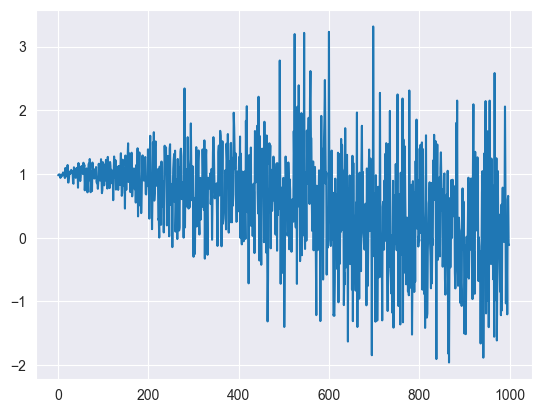

In [6]:
import seaborn as sns

sns.lineplot(
    x=list(range(num_timesteps)),
    y=lin.numpy()
)

In [7]:
def get_all_directories_for_a_path(
    path: Path,
    return_only_directories: bool = True,
    return_no_hidden_directories: bool = True,
):
    result = os.listdir(path)
    if return_only_directories:
        result = [
            directory
            for directory in result
            if os.path.isdir(os.path.join(path, directory))
        ]
    if return_no_hidden_directories:
        result = [
            directory for directory in result if not str(directory).startswith(".")
        ]
    return result

In [8]:
test_models = perform_train_test_validation_split(
    list_to_split=get_all_directories_for_a_path("/Users/alexanderlontke/Documents/Uni/St. Gallen/HS_22_23/integrative_master_project/data/tune_zoo_mnist_uniform"),
    dataset_split_ratios=[7,3],
    split="test"
)

In [9]:
len(test_models)

300

In [10]:
config_path = "/Users/alexanderlontke/Documents/Uni/St. Gallen/HS_22_23/integrative_master_project/weight-diffusion/configs/ldm/hp-ldm.yaml"

import yaml

with open(config_path, "r") as config_file:
    config = yaml.safe_load(config_file)

dataset = ModelZooWithLatentDataset(
    data_dir=Path(
        "/Users/alexanderlontke/Documents/Uni/St. Gallen/HS_22_23/integrative_master_project/data/tune_zoo_mnist_uniform")
    ,
    split="irrelevant",
    checkpoint_property_of_interest="test_acc",
    openai_coefficient=config["openai_coefficient"],
    number_of_permutations=10,
    device="cpu",
    model_directory_paths=test_models[:10],
    encoder_config=config["encoder_config"],
    tokenizer_config=config["tokenizer_config"],
)

init attn encoder
## encoder -- use index_dict
model: use only positive contrast loss
initialze projection head


Loading Models:   0%|          | 0/10 [00:00<?, ?it/s]

compute 2 random permutations for layer 0 - 0
compute 2 random permutations for layer 1 - 3
compute 2 random permutations for layer 2 - 6
compute 2 random permutations for layer 3 - 9
prepared 10 permutations
prepare permutation dicts


Indexing dataset: 100%|██████████| 10/10 [00:00<00:00, 2812.89it/s]


In [11]:
len(dataset)

4900

In [12]:
dataset[123]["checkpoint_latent"]

tensor([[ 2.0975e-02, -4.1887e-01, -5.2317e-01,  1.4149e-01, -2.7036e-01,
          4.4620e-02, -1.9806e-01,  4.2351e-01,  6.8718e-01,  1.8589e-02,
          2.5424e-01,  4.9307e-01,  3.7705e-02, -4.6269e-01, -2.0493e-01,
          1.5771e-01,  1.4049e-01, -5.4722e-01, -2.6889e-01, -9.3190e-02,
         -1.3580e-01,  1.7182e-01,  1.3497e-01,  1.0057e-01,  3.7298e-01,
         -1.0305e-01,  1.5180e-02,  1.2006e-01, -1.3686e-01, -2.4391e-01,
         -2.2261e-01,  2.6131e-01, -9.5583e-02, -1.4569e-01,  1.6364e-01,
         -3.8748e-01, -5.7922e-02, -3.5640e-01,  3.1680e-01,  7.3367e-01,
          1.6974e-01,  7.4830e-02, -3.1017e-01,  1.0818e-01, -3.9292e-01,
         -3.0728e-01, -9.4471e-02, -9.1201e-01,  7.3672e-02,  9.6850e-03,
         -1.7208e-01, -1.0789e-01, -4.6013e-01, -1.9241e-01, -1.3265e-01,
          3.3579e-01,  1.0652e-01, -2.6389e-01,  3.4585e-01, -5.0670e-02,
          1.2395e-01, -2.2193e-01, -4.1391e-03, -9.3902e-01,  5.4980e-01,
         -3.5363e-01, -2.1872e-02, -9.

In [13]:
q_sample(
    x_start=dataset[123]["checkpoint_latent"],
    t=torch.tensor([999]),
    sqrt_alphas_cumprod=sqrt_alphas_cumprod,
    sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod
)

tensor([[-3.6759e-03, -3.5262e-02, -8.1052e-01,  5.2530e-01, -2.7798e+00,
         -2.4609e+00, -6.8350e-01,  3.2797e-01,  2.5522e-01, -9.8551e-01,
          1.0330e-01, -1.9024e-01,  4.0451e-01,  8.2455e-01, -2.3189e+00,
          3.4542e-01, -1.3053e+00, -1.1093e+00, -7.9087e-01,  3.2712e-02,
         -6.6260e-01,  1.1713e+00,  2.3131e-01,  5.1582e-01,  8.4966e-01,
         -3.8366e-01,  1.1256e+00,  1.0335e+00, -2.2257e-01, -7.1372e-01,
         -3.4770e-01,  2.0241e+00, -4.4361e-01, -9.0084e-01,  1.5952e-02,
          1.3316e-02,  5.0816e-01,  1.0477e+00, -1.6029e+00, -1.2991e-01,
         -1.3095e+00,  2.9429e-01,  1.2453e-01,  2.1777e-01, -1.6565e+00,
          1.3832e-01,  1.5709e+00, -8.2683e-01,  3.2741e-03,  1.6907e+00,
         -7.6774e-01, -7.1871e-01, -1.2052e-01, -8.6801e-01,  1.0678e+00,
          3.4345e-01,  4.0203e-01,  4.6290e-01, -4.2126e-01,  6.1167e-01,
          1.8296e-01, -4.0939e-01,  1.0927e+00,  5.1827e-01, -1.0496e+00,
          3.9655e-01,  3.1713e-02,  1.

In [14]:
from weight_diffusion.execution.util import load_model_from_config

with open("/Users/alexanderlontke/Documents/Uni/St. Gallen/HS_22_23/integrative_master_project/weight-diffusion/configs/evaluate/config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)["ldm_config"]

model = load_model_from_config(
    config=config,
    ckpt="/Users/alexanderlontke/Desktop/last.ckpt"
)

Loading model from /Users/alexanderlontke/Desktop/last.ckpt
Global Step: 35680
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 189.43 M params.


In [15]:
# model(
#     q_sample(
#         x_start=dataset[123]["checkpoint_latent"],
#         t=torch.tensor([999]),
#         sqrt_alphas_cumprod=sqrt_alphas_cumprod,
#         sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod
#     ),
#     c=torch.Tensor([[*dataset[123]["prompt_latent"]]])
# )
shape = dataset[123]["checkpoint_latent"].shape
sample = sample_from_prompt(
    prompt=torch.Tensor([[0.16126, 0.1999, 0.1995]]), # torch.Tensor([[*dataset[123]["prompt_latent"]]]),
    sampling_steps=2,
    shape=shape,
    guidance_scale=1.0,
    uc=None,
    model=model,
)
sample

/Users/alexanderlontke/.conda/envs/weight-diffusion/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Data shape for DDIM sampling is torch.Size([1, 700]), eta 0.0
Running DDIM Sampling with 2 timesteps


DDIM Sampler: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


tensor([[[ 0.8303, -0.8664,  1.6484,  0.8583, -2.0771,  1.4131,  0.2065,
          -2.0389, -0.5182,  0.9682, -0.7868, -4.0116, -3.6786,  2.7640,
          -1.0665, -2.7312,  0.3971, -1.7152,  1.2338,  2.9554, -2.1951,
           0.1340,  2.1041,  5.4957, -3.3280,  1.4991,  0.3112, -5.2185,
           1.5549,  1.5532,  2.0343, -3.8010,  1.9703, -2.6125,  3.5900,
           8.4193, -3.8773,  0.3955, -3.8989, -0.7704, -0.3775,  7.2359,
          -5.1251, -5.2345,  5.1068,  0.5743,  4.9388,  3.1008,  2.0610,
          -3.3508,  3.4349,  3.1713, -4.2582,  0.2928, -1.1844, -4.7322,
          -1.5488,  4.3290,  0.1678, -2.5766,  3.3558,  1.0833,  3.0410,
          -0.3421,  1.0890,  5.2120,  1.9977,  2.4489,  0.1312,  0.2418,
           0.0904,  0.1069,  0.9417, -2.0567,  2.7617, -0.7379,  0.8543,
          -2.3118,  0.4813,  1.1849, -1.4047,  4.1063,  0.1319,  6.9063,
          -0.6441,  6.1068, -3.8716,  1.3945,  1.4239,  2.3140, -0.1554,
          -0.8970,  2.4789,  2.5807, -0.7851,  4.34

In [1]:
torch.Tensor([[*dataset[100]["prompt_latent"]]])

NameError: name 'torch' is not defined

In [17]:
torch.Tensor([[*dataset[123]["prompt_latent"]]])

tensor([[0.6701, 0.6753, 0.6802]])

In [21]:
!pip freeze | grep latent

-e git+ssh://git@github.com/AlexanderLontke/stable-diffusion.git@98157a2bceee449b9716d773000ba2d67b6ae252#egg=latent_diffusion
